In [1]:
# visualization tools
import matplotlib
matplotlib.use("cairo")
import matplotlib.pyplot as plt
plt.switch_backend("cairo")
import seaborn as sns

%matplotlib inline
%autosave 15

Autosaving every 15 seconds


In [27]:
# utilities
from collections import defaultdict
import gc
import itertools
from time import time
import warnings
# jupyter-notebook specific utilities
from tqdm import *
# graph processing
import graph_tool.all as gt
# multiprocessing utilities
import joblib
import multiprocessing as mp
# scientific computing libraries
import numpy as np
import scipy as sp
import scipy.stats as sps

gc.enable()
warnings.filterwarnings('ignore') 

## Реализация алгоритма
Приведём реализацию предложенного 2-оптимального алгоритма, используя примитивы из ```graph-tool```.
**Осторожно!** Код написан для работы в режиме максимальной производительности, самостоятельный запуск ячеек займёт все ядра и может подвесить операционную систему.  
Здесь и далее оранжевым цветов выделен результат работы алгоритма, голубым — настоящее дерево Штейнера, зелёным — рёбра, лежащие и там, и там. Каждый запуск выдаёт три числа: приближённый вес дерева Штейнера, его реальный вес и отношение первого ко

In [66]:
%%time
def powerset(iterable):
    """
    Returns an iterator over subsets of iterable.
    """
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))


def steiner_tree_2_opt(G, V0):
    """
    Given weighted undirected graph, finds an approximation to the Steiner tree
    that has at least two times larger cost than the actual tree.с 
    
    @param G — graph_tool.Graph. Must have an edge-property "w" — the edge weights.
    @param V0 — np.array, a subset of indices corresponding to the terminal vertices.
    @return (np.float32, np.array), the cost and the tree
    """
    n = G.num_vertices()
    # Calculate all-pairs shortest distances using Floyd's algorithm
    sd_pm = gt.shortest_distance(G, weights=G.ep["w"], 
                                 directed=False, dense=True)
    sd = np.vstack([sd_pm[v] for v in G.vertices()])
    # Construct the metric closure
    K_n = gt.complete_graph(n, directed=False)
    K_n.ep["w"] = K_n.new_edge_property("double")
    indices = np.triu_indices_from(sd, k=1) # https://vk.cc/8D03ZI
    K_n.ep["w"].a = np.ravel(np.asarray(sd[indices]))
    # Subselect the subgraph induced by the terminal nodes
    V0_vfilt = K_n.new_vertex_property("bool")
    V0_vfilt.a[V0] = True
    K_V0 = gt.GraphView(K_n, vfilt=V0_vfilt.a)
    # Find the MST in that induced subgraph
    MST = gt.min_spanning_tree(K_V0, weights=K_n.ep["w"])
    mst_cost = np.sum(K_n.ep["w"].a[MST.a == 1])
    mask_2_opt = G.new_ep("bool")
    edges_before, edges_after = 0, 0
    for e in K_V0.edges():
        if MST[e]:
            edges_before += 1
            u, v = G.vertex(int(e.source())), G.vertex(int(e.target()))
            vpath, epath = gt.shortest_path(G, u, v, weights=G.ep["w"])
            for ee in epath:
                edges_after += 1
                mask_2_opt[ee] = True
    return mst_cost, mask_2_opt 


__cost_opt, __tree_opt = np.inf, None
def steiner_tree(G, V0):
    global __cost_opt, __tree_opt
    __cost_opt, __tree_opt = np.inf, None
    # Как тут получить argmin? Причём хотелось бы не за экспоненту памяти...
    """
    Given weighted undirected graph, finds an actual Steiner tree in exponential time
    
    @param G — graph_tool.Graph. Must have an edge-property "w" — the edge weights.
    @param V0 — np.array, a subset of indices corresponding to the terminal vertices.
    @return (np.float32, np.array), the cost and the tree
    """
    def process_mask(subset):
        global __cost_opt, __tree_opt
        """
        Implementation of the main logic that gets plugged into joblib.Parallel.
        Subselects the subgraph induced by the terminal nodes and some other 
        nodes specified in "subset", finds MST in it and returns its cost.
        """
        mask = np.full(G.num_vertices(), False)
        mask[V0] = True
        if len(subset) > 0:
            mask[np.array(subset)] = True
        H = gt.GraphView(G, vfilt=mask)
        conn = gt.label_largest_component(H)
        if np.sum(conn.a) != np.sum(mask):
            return np.inf # not connected
        H_MST = gt.min_spanning_tree(H, weights=H.ep["w"])
        h_mst_cost = np.sum(H.ep["w"].a[H_MST.a == 1])
        if h_mst_cost <= __cost_opt:
            __cost_opt = h_mst_cost
            __tree_opt = H_MST
        return h_mst_cost
    # перебор подмножеств легко распараллеливается
    # все итерации цикла независимы друг от друга
    st_cost = np.asscalar(np.min(joblib.Parallel(n_jobs=mp.cpu_count(), require="sharedmem")(
        joblib.delayed(process_mask)(s)
        for s in tqdm_notebook(powerset(np.setdiff1d(np.arange(n), V0)))
    )))
    return st_cost, __tree_opt.copy()


def highlight_steiner_trees(G, mask_opt, mask_2_opt):
    G.ep["c"] = G.new_ep("string")
    G.ep["label"] = G.new_ep("string")
    for e in G.edges():
        if mask_opt[e] and mask_2_opt[e]:
            G.ep["c"][e] = "xkcd:emerald green"
        elif mask_opt[e]:
            G.ep["c"][e] = "xkcd:azure"
        elif mask_2_opt[e]:
            G.ep["c"][e] = "xkcd:tangerine"
        else:
            G.ep["c"][e] = "gray"
        G.ep["label"][e] = "{:.2f}".format(G.ep["w"][e])

CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 20.5 µs


## Последовательности графов с известным ответом

1. Патологическая последовательность, на которой в пределе достигается наихудшее приближение — с коэффициентом 2. Терминальные вершины выделены красным. Реальное дерево Штейнера имеет вес $ |V_{0}| $ выделено голубым цветом, а построенное алгоритмом имеет вес $ 2|V_{0}| - 2 $ и выделено оранжевым. Причина такого расхождения в логике работы алгоритма: подграф метрического замыкания, индуцированный множеством терминальных вершин это внешний цикл (из рёбер веса 2), рёбра веса 1 туда банально не попадают.  
   Итоговое качество аппроксимации — $ 2 - \frac{2}{|V_{0}|} $.

Number of terminal nodes: 3
Actual answer: 3
Algorithm's ouptut: 4.0
Ratio: 1.3333333333333333 = 2 - 2 / 3


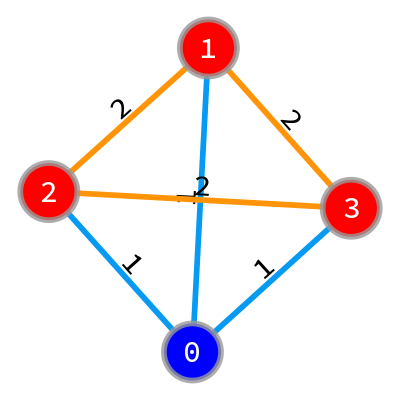

Number of terminal nodes: 5
Actual answer: 5
Algorithm's ouptut: 8.0
Ratio: 1.6 = 2 - 2 / 5


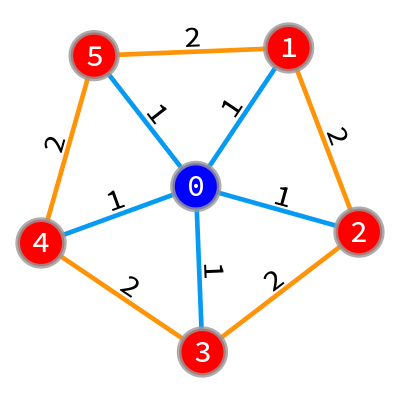

Number of terminal nodes: 7
Actual answer: 7
Algorithm's ouptut: 12.0
Ratio: 1.7142857142857142 = 2 - 2 / 7


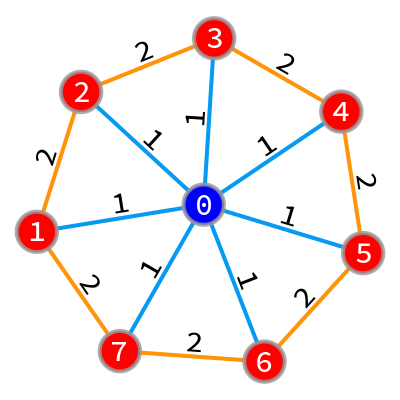

Number of terminal nodes: 9
Actual answer: 9
Algorithm's ouptut: 16.0
Ratio: 1.7777777777777777 = 2 - 2 / 9


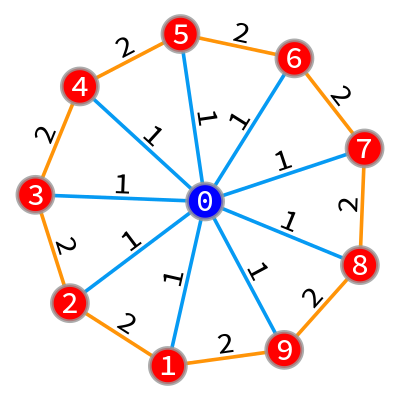

In [74]:
test_cases = 7
min_vertices = 3
for i, n in enumerate(min_vertices + np.arange(test_cases)[::2] + 1):
    G = gt.Graph(directed=False)
    G.ep["w"] = G.new_ep("double")
    G.ep["label"] = G.new_ep("string")
    G.ep["color"] = G.new_ep("string")
    G.vp["c"] = G.new_vp("string")
    for j in range(n):
        v = G.add_vertex()
        G.vp["c"][v] = "blue" if j == 0 else "red"
    for j in range(1, n):
        e_inner = G.add_edge(0, j)
        e_outer = G.add_edge(j, max(1, (j + 1) % n))
        G.ep["w"][e_outer] = 2
        G.ep["w"][e_inner] = 1
        G.ep["color"][e_inner] = "xkcd:azure"
        G.ep["color"][e_outer] = "xkcd:tangerine"
        G.ep["label"][e_outer] = "2"
        G.ep["label"][e_inner] = "1"
    V0 = np.arange(1, n)
    cost_2_opt = steiner_tree_2_opt(G, V0)[0]
    num_terminal_vs = n - 1 
    print("Number of terminal nodes: {}\nActual answer: {}\nAlgorithm's ouptut: {}\nRatio: {} = 2 - 2 / {}"\
          .format(num_terminal_vs, num_terminal_vs, 
                  cost_2_opt, cost_2_opt / num_terminal_vs, 
                  num_terminal_vs)
    )
    gt.graph_draw(G,
                  vprops={"text" : G.vertex_index, 
                          "fill_color" : G.vp["c"],
                          "font_size" : 30},
                  eprops={"text" : G.ep["label"], 
                          "color" : G.ep["color"],
                          "font_size" : 30}, 
                  output_size=(400,400));    

2. Если $|V| = |V_0|$, то дерево Штейнера совпадает с минимальным остовным деревом.  
   Тривиальные тесты тоже бывают полезны: можно рано поймать дурацкий баг в реализации.

|V| = 5, |V0| = 5, |E| = 10


True cost: 82.0
Algorithm's output: 82.0
Ratio: 1.0


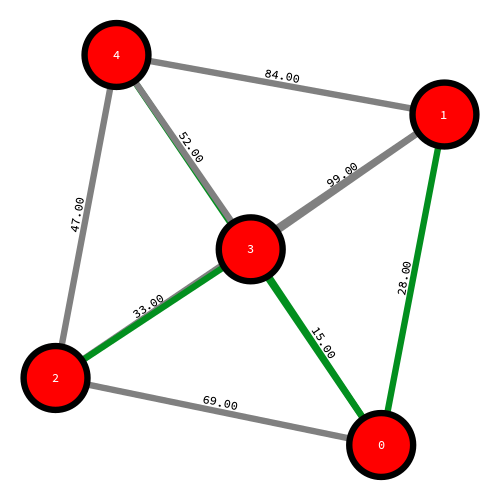

|V| = 6, |V0| = 6, |E| = 15


True cost: 72.0
Algorithm's output: 72.0
Ratio: 1.0


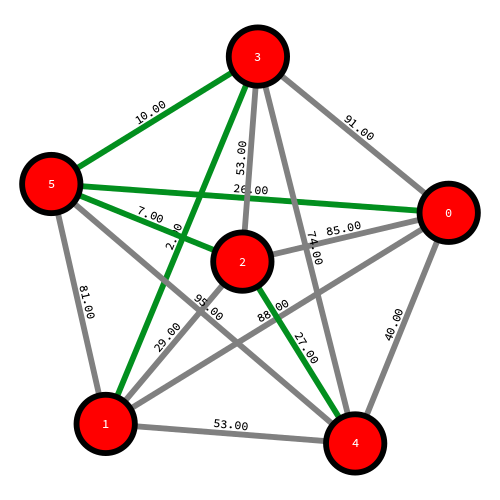

|V| = 7, |V0| = 7, |E| = 21


True cost: 104.0
Algorithm's output: 104.0
Ratio: 1.0


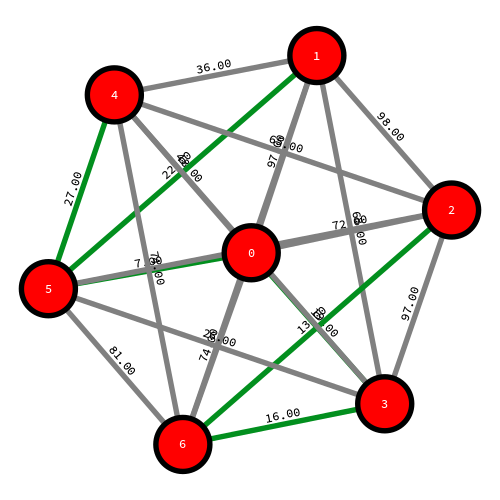

In [77]:
n_list = np.array([5, 6, 7])
k_list = n_list

for i in range(len(n_list)):
    n, k = n_list[i], k_list[i]
    G = gt.complete_graph(n, directed=False);
    G.ep["w"] = G.new_ep("double")
    G.ep["w"].a = np.random.randint(low=1, high=100, size=G.num_edges())
    G.vp["fc"] = G.new_vp("string")
    G.vp["c"] = G.new_vp("string")
    V0 = np.random.choice(np.arange(n),  k, replace=False)
    for v in G.vertices():
        G.vp["fc"][v] = "red" if int(v) in V0 else "xkcd:sky blue"
        G.vp["c"][v] = "black"
    print("|V| = {}, |V0| = {}, |E| = {}".format(n, k, G.num_edges()))
    cost_2_opt, mask_2_opt = steiner_tree_2_opt(G, V0)
    cost_opt, mask_opt = steiner_tree(G, V0)
    highlight_steiner_trees(G, mask_opt, mask_2_opt)
    print("True cost: {}\nAlgorithm's output: {}\nRatio: {}".format(
        cost_opt, cost_2_opt, cost_2_opt / cost_opt
    ))
    gt.graph_draw(G, 
                  vprops={"fill_color" : G.vp["fc"], 
                          "text" : G.vertex_index, 
                          "color" : G.vp["c"]},
                  eprops={"color" : G.ep["c"], 
                          "text" : G.ep["label"]},
                  output_size=(500, 500));

## Случайные графы в модели Эрдёша-Реньи

Сгенерируем случайные графы в модели Эрдёша-Реньи (ну, почти; в graph-tool ничего более похожего сделать не удалось). Ответ для них заранее неизвестен, но их структура достаточно непредсказуема, чтобы избежать ситуации, когда алгоритм работает только на тех графах, которые понимает автор.

|V| = 5, |V0| = 3, |E| = 9, p = 0.8


64.15070142655716 57.942534568817166 1.107143515621787


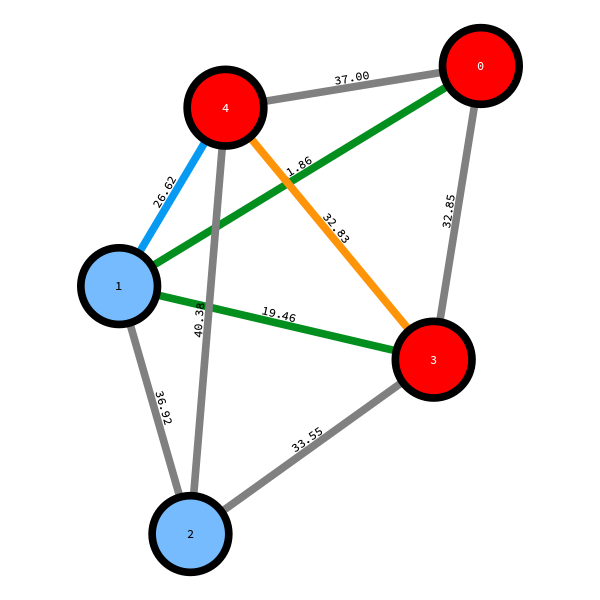

|V| = 10, |V0| = 4, |E| = 25, p = 0.5


12.562121139399057 12.562121139399057 1.0


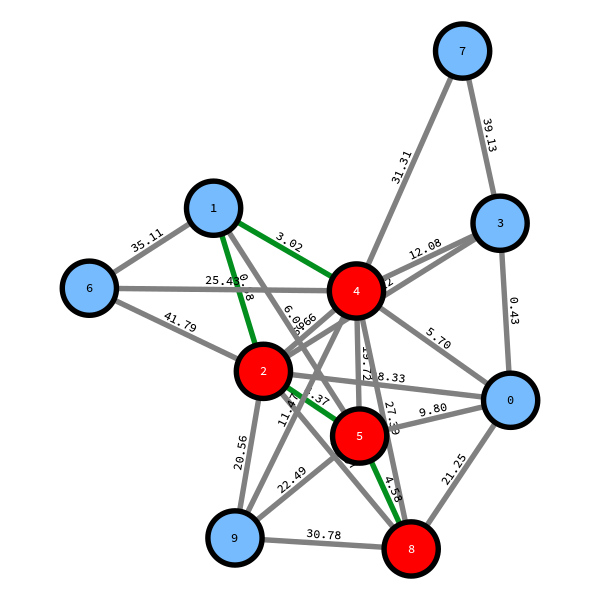

|V| = 15, |V0| = 6, |E| = 30, p = 0.3


99.71981877125141 89.73448246728798 1.1112764684145084


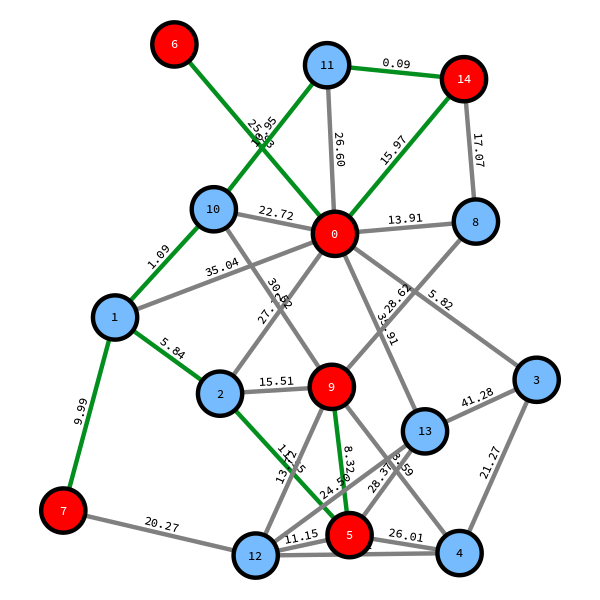

In [69]:
np.random.seed(int(time()))
n_list = np.array([5, 10, 15])
k_list = np.array([3, 4, 6])
p_list = np.array([0.8, 0.5, 0.3])

for i in range(len(n_list)):
    n, k, p = n_list[i], k_list[i], p_list[i]
    G = gt.random_graph(n, lambda: np.random.poisson(n * p), directed=False);
    conn = gt.label_largest_component(G)
    if np.sum(conn.a) != n:
        i -= 1
        continue
    G.ep["w"] = G.new_ep("double")
    G.ep["w"].a = np.random.rand(G.num_edges()) * 42
    G.vp["fc"] = G.new_vp("string")
    G.vp["c"] = G.new_vp("string")
    V0 = np.random.choice(np.arange(n),  k, replace=False)
    for v in G.vertices():
        G.vp["fc"][v] = "red" if int(v) in V0 else "xkcd:sky blue"
        G.vp["c"][v] = "black"
    print("|V| = {}, |V0| = {}, |E| = {}, p = {}".format(n, k, G.num_edges(), p))
    cost_2_opt, mask_2_opt = steiner_tree_2_opt(G, V0)
    cost_opt, mask_opt = steiner_tree(G, V0)
    print(cost_2_opt, cost_opt, cost_2_opt / cost_opt)
    highlight_steiner_trees(G, mask_opt, mask_2_opt)
    gt.graph_draw(G, 
                  vprops={"fill_color" : G.vp["fc"], 
                          "text" : G.vertex_index, 
                          "color" : G.vp["c"]},
                  eprops={"color" : G.ep["c"], 
                          "text" : G.ep["label"]},
                  output_size=(600, 600));

## Полные графы со случайными весами и множествами терминальных вершин

Этот блок тестов проверяет эффективность реализации: несмотря на тривиальность структуры, полные графы вычислительно "тяжёлые", что заметно замедляет их обработку даже с поправкой на экспоненциальную асимптотику точного алгоритма.

|V| = 11, |V0| = 3, |E| = 55, p = 0.3


17.919870322322716 17.919870322322716 1.0


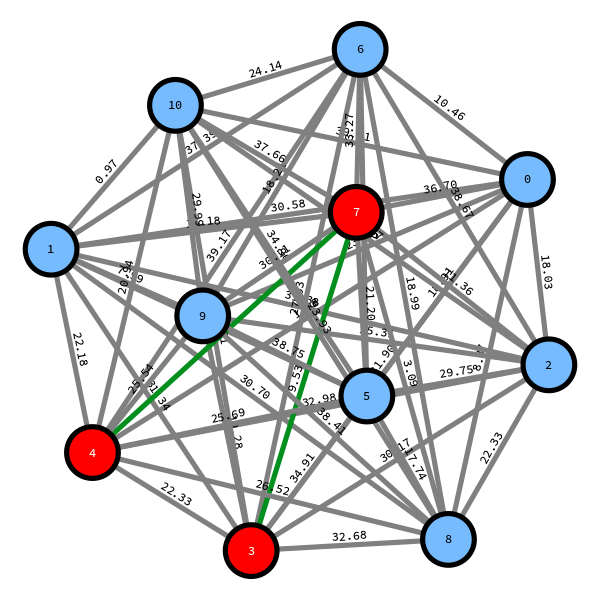

|V| = 13, |V0| = 3, |E| = 78, p = 0.3


25.57939583017063 25.163068350936793 1.0165451793647549


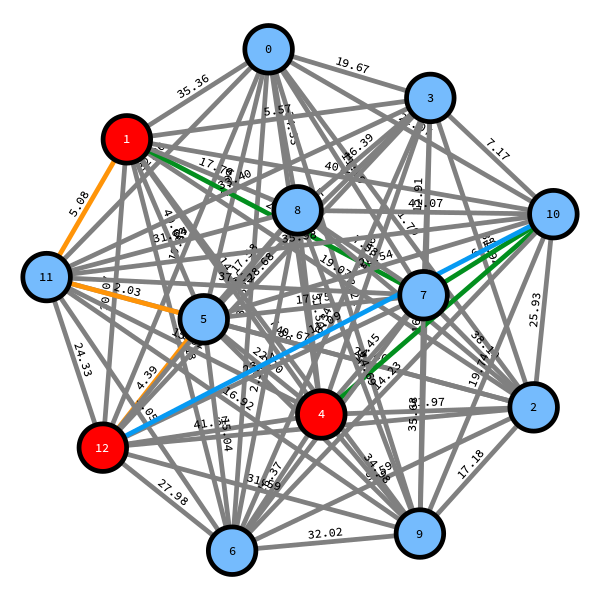

|V| = 15, |V0| = 2, |E| = 105, p = 0.3


12.07478586037659 12.07478586037659 1.0


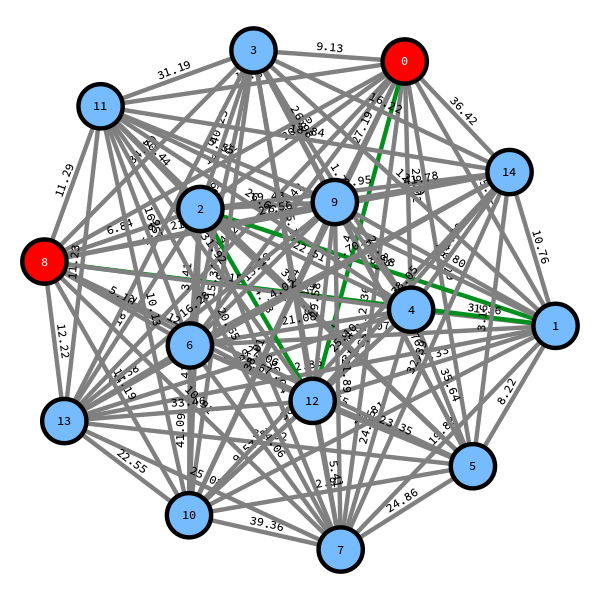

In [73]:
n_list = np.random.randint(low=3, high=16, size=3)
k_list = np.array([max(2, np.random.randint(low=1, high=n)) for n in n_list])

for i in range(len(n_list)):
    n, k = n_list[i], k_list[i]
    G = gt.complete_graph(n, directed=False);
    G.ep["w"] = G.new_ep("double")
    G.ep["w"].a = np.random.rand(G.num_edges()) * 42
    G.vp["fc"] = G.new_vp("string")
    G.vp["c"] = G.new_vp("string")
    V0 = np.random.choice(np.arange(n),  k, replace=False)
    for v in G.vertices():
        G.vp["fc"][v] = "red" if int(v) in V0 else "xkcd:sky blue"
        G.vp["c"][v] = "black"
    print("|V| = {}, |V0| = {}, |E| = {}, p = {}".format(n, k, G.num_edges(), p))
    cost_2_opt, mask_2_opt = steiner_tree_2_opt(G, V0)
    cost_opt, mask_opt = steiner_tree(G, V0)
    highlight_steiner_trees(G, mask_opt, mask_2_opt)
    print(cost_2_opt, cost_opt, cost_2_opt / cost_opt)
    gt.graph_draw(G, 
                  vprops={"fill_color" : G.vp["fc"], 
                          "text" : G.vertex_index, 
                          "color" : G.vp["c"]},
                  eprops={"color" : G.ep["c"], 
                          "text" : G.ep["label"]},
                  output_size=(600, 600));